[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\udays\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Scraped page 1
Scraped page 2
Scraped page 3
Scraped page 4
Scraped page 5
Scraped page 6
Scraped page 7
Scraped page 8
Scraped page 9
Scraped page 10
Scraped page 11
Scraped page 12
Scraped page 13
Scraped page 14
Scraped page 15
Scraped page 16
Scraped page 17
Scraped page 18
Scraped page 19
Scraped page 20
Scraped page 21
Scraped page 22
Scraped page 23
Scraped page 24
Scraped page 25
Scraped page 26
Scraped page 27
Scraped page 28
Scraped page 29
Scraped page 30
Scraped page 31
Scraped page 32
Scraped page 33
Scraped page 34
Scraped page 35
Scraped page 36
Scraped page 37
Scraped page 38
Scraped page 39
Scraped page 40
Scraped page 41
Scraped page 42
Scraped page 43
Scraped page 44
Scraped page 45
Scraped page 46
Scraped page 47
Scraped page 48
Scraped page 49
Scraped page 50
Scraped page 51
Scraped page 52
Scraped page 53
Scraped page 54
Scraped page 55
Scraped page 56
Scraped page 57
Scraped page 58
Scraped page 59
Scraped page 60
Scraped page 61
Scraped page 62
Scraped page 63
S

C:\Users\udays\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\udays\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\udays\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


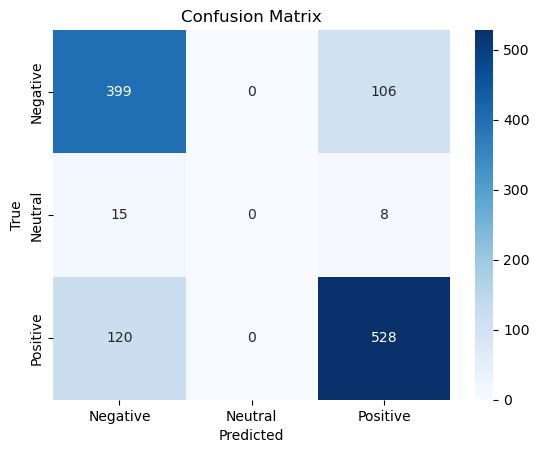

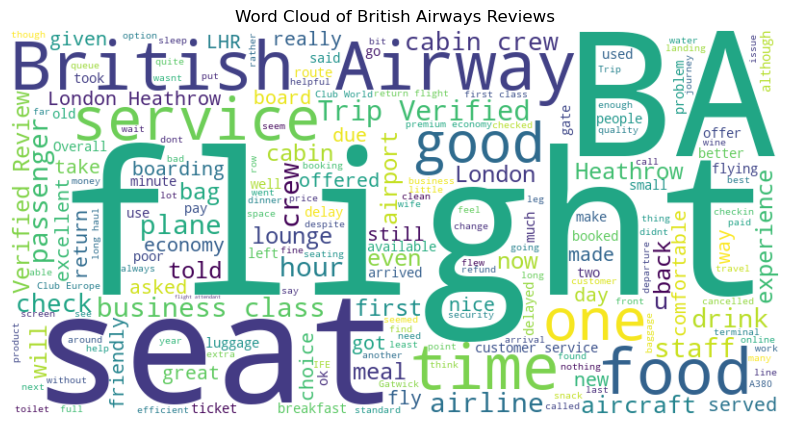


Sentiment Distribution:
 Sentiment_Label
Positive    2233
Negative    1624
Neutral       60
Name: count, dtype: int64


In [65]:
# Importing necessary libraries
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
import re
from time import sleep
from random import randint


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Ensure necessary NLTK data is available
nltk.download('vader_lexicon')

# Function to scrape reviews from Skytrax
def scrape_reviews(url, num_pages=100):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    reviews = []
    
    for page in range(1, num_pages + 1):
        page_url = f"{url}/page/{page}/?sortby=post_date%3ADesc&pagesize=100"
        response = requests.get(page_url, headers=headers)
        
        if response.status_code != 200:
            print(f"Failed to retrieve data from {page_url}")
            continue

        soup = BeautifulSoup(response.content, 'html.parser')
        review_elements = soup.find_all('div', class_='text_content')
        
        for element in review_elements:
            review = element.get_text(strip=True)
            reviews.append(review)
        
        print(f"Scraped page {page}")
        sleep(randint(1, 3))  # Random delay to avoid detection
    
    return reviews

# Define the Skytrax URL for British Airways
url = "https://www.airlinequality.com/airline-reviews/british-airways"

# Scrape the reviews (increase num_pages for more data)
reviews = scrape_reviews(url, num_pages=100)

# Ensure 'data' directory exists
os.makedirs("data", exist_ok=True)

# Save raw reviews to CSV
reviews_df = pd.DataFrame(reviews, columns=['Review'])
reviews_df.to_csv('data/raw_reviews.csv', index=False)

# Load the reviews
reviews_df = pd.read_csv('data/raw_reviews.csv')

# Data Cleaning: Remove special characters, extra spaces, and empty reviews
reviews_df['Review'] = reviews_df['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', str(x)).strip())
reviews_df = reviews_df[reviews_df['Review'] != '']  # Remove empty rows

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
reviews_df['Sentiment_Score'] = reviews_df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

reviews_df['Sentiment_Label'] = reviews_df['Sentiment_Score'].apply(classify_sentiment)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    reviews_df['Review'], reviews_df['Sentiment_Label'], test_size=0.3, random_state=42
)

# Convert the reviews into numerical features using TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




# Generate and visualize a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(reviews_df['Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of British Airways Reviews")
plt.show()

# Basic sentiment analysis summary
sentiment_summary = reviews_df['Sentiment_Label'].value_counts()
print("\nSentiment Distribution:\n", sentiment_summary)

# Save cleaned & analyzed data
reviews_df.to_csv('data/reviews_with_sentiment.csv', index=False)


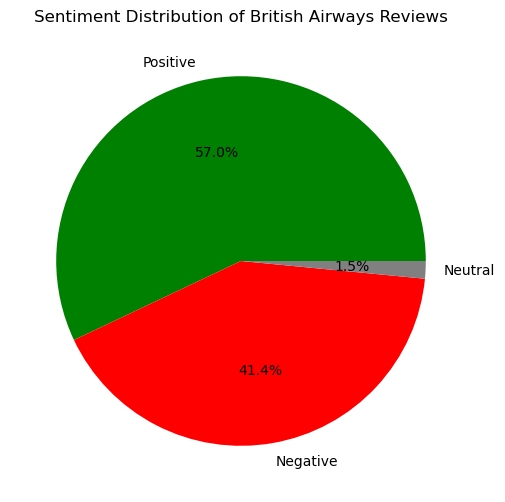

In [60]:
# Plot Sentiment Distribution (Pie Chart)
plt.figure(figsize=(6, 6))
sentiment_summary.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title("Sentiment Distribution of British Airways Reviews")
plt.ylabel("")  # Hide y-label for better visualization
plt.show()


Accuracy: 79.25%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.80      0.77       488
     Neutral       0.00      0.00      0.00        23
    Positive       0.83      0.82      0.83       665

    accuracy                           0.79      1176
   macro avg       0.52      0.54      0.53      1176
weighted avg       0.78      0.79      0.79      1176


Confusion Matrix:


C:\Users\udays\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\udays\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\udays\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


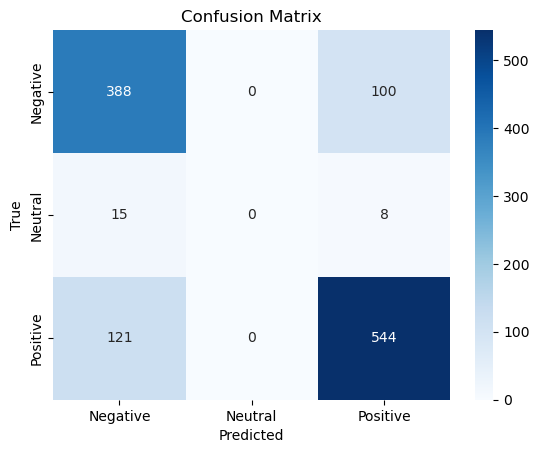

In [63]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    reviews_df['Review'], reviews_df['Sentiment_Label'], test_size=0.3, random_state=42
)

# Convert the reviews into numerical features using TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


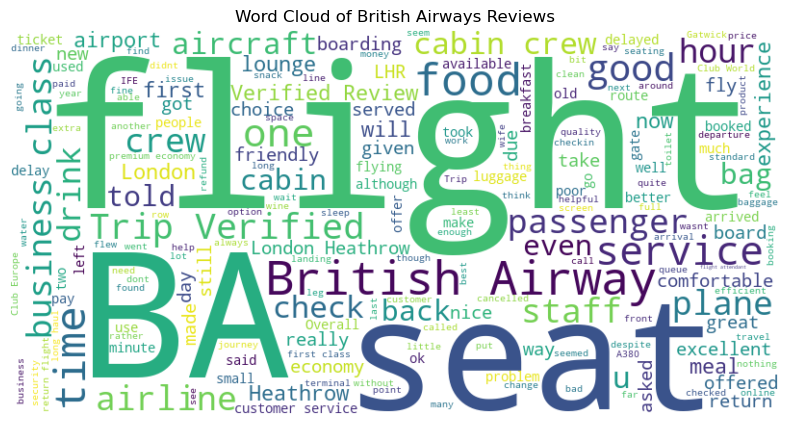

In [67]:
# Generate and visualize a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(reviews_df['Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of British Airways Reviews")
plt.show()